In [1]:
import numpy as np
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import invgamma
import matplotlib.pyplot as plt
import copy
import pandas as pd
import scipy.stats as stats

In [2]:
# Define log_Normal pdf
def log_Normal(x, true_mu, true_sigma):
    log_norm = (np.exp(-(np.log(abs(x)) - true_mu)**2 / (2 * true_sigma**2))) / (abs(x) * true_sigma * np.sqrt(2 * np.pi))
    return log_norm

# Define function for thresholding components of dataset using Otsu's Method
def Otsu_method(data, n_bins):
    var_B_max = 0
    k1_max = 0
    k2_max = 0
    
    # Create histogram of data with defined number of bins and normalize to form probability density
    count, bins, ignored = plt.hist(data, bins = n_bins, density = True)
    for i in range(1, (len(bins)-2)):
        k2 = bins[i]
        for j in range(0, i):
            k1 = bins[j]
            
            w_0 = np.sum(count[0:j])
            w_1 = np.sum(count[j:i])
            w_2 = np.sum(count[i:])
            
            mu_0 = np.sum(bins[0:j]*(count[0:j]/w_0))
            mu_1 = np.sum(bins[j:i]*(count[j:i]/w_1))
            mu_2 = np.sum(bins[i:-1]*(count[i:]/w_2))
            
            var_0 = np.sum((bins[0:j] - mu_0)**2 * (count[0:j]/w_0))
            var_1 = np.sum((bins[j:i] - mu_1)**2 * (count[j:i]/w_1))
            var_2 = np.sum((bins[i:-1] - mu_2)**2 * (count[i:]/w_2))
            
            mu_T = w_0*mu_0 + w_1*mu_1 + w_2*mu_2
                
            var_B = w_0*(mu_0 - mu_T)**2 + w_1*(mu_1 - mu_T)**2 + w_2*(mu_2 - mu_T)**2
            if var_B > var_B_max:
                var_B_max = var_B
                k1_max = k1
                k2_max = k2
                
    return [var_B_max, k1_max, k2_max]

# Import dendrite branch velocity data

In [3]:
velocity_data = pd.read_csv('unmerged_velocity_data.csv')
velocity_data = np.array(velocity_data)
velocity_data = velocity_data[np.where(velocity_data)]  # This is a strange way to merge data into one array, but it does the job

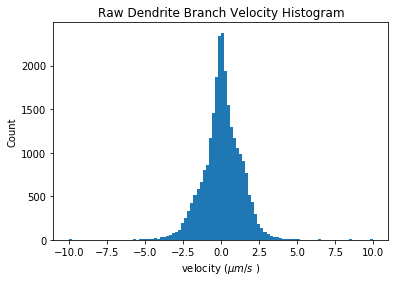

In [4]:
count, bins, ignored = plt.hist(velocity_data, bins=100)
plt.title('Raw Dendrite Branch Velocity Histogram')
plt.xlabel(r'velocity ($\mu m/s$ )')
plt.ylabel('Count')

x = np.linspace(min(bins), max(bins), 1000)

C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


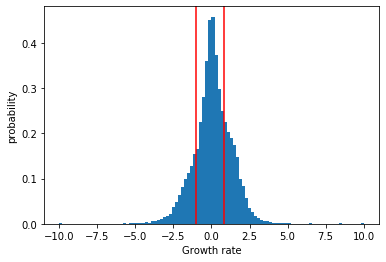

k1:  -1.0 ; k2:  0.8


In [5]:
# Compute threshold values and plot using Otsu's Method
[var_B_max, k1, k2] = Otsu_method(velocity_data, 100)

# plt.hist(velocity_data, bins = 100, density = True)
plt.axvline(k1, color = 'r')
plt.axvline(k2, color = 'r')
plt.xlabel('Growth rate')
plt.ylabel('probability')
plt.show()

print('k1: ', round(k1,3), '; k2: ', round(k2,3))

# Gibbs Sampling Algorithm

In [6]:
# Define functions for sampling from distributions
# Sample n categorical random variables into 2 categories with probabilities p1 and p2 (n = len(data_set))
def Categorical_var(n, neg_len, p1, p2, p3):
    cat_var = []
    for i in range(n):
        if type(p1) and type(p2) and type(p3) == float:
            s_i = np.random.multinomial(1,[p1, p2, p3]) 
            s_i = np.where(s_i == 1)[0][0] + 1
        else:
            # s_i = np.random.multinomial(1,[p1[i], p2[i], p3[i]])  # ***Multinomial distribution has some bug!!!
            
            # if p1[i] < p_thresh:
            #    s_i = np.random.multinomial([p2[i],p3[i]])
            #    s_i = np.where(s_i == 1)[0][0] + 2 
            # elif p2[i] < p_thresh:
            #    s_i = np.random.multinomial([p2[i],p3[i]])
                
            if i < neg_len:   
                s_i = np.random.multinomial(1, [p2[i],p3[i]]) 
                s_i = np.where(s_i == 1)[0][0] + 2              
                    
            else: 
                s_i = np.random.multinomial(1, [p1[i],p2[i]])
                s_i = np.where(s_i == 1)[0][0] + 1
                
        
        cat_var.append(s_i)
    cat_var = np.array(cat_var)
    return cat_var

# Sample precision (tao) parameter from inverse gamma posterior of Gaussian likelihood model
def tau_param(alpha, beta, A, set_A, mean, n_0, mu_0):
    alpha_prime = alpha + A/2
    beta_prime = beta + 0.5*sum((set_A - mean)**2) + (((A*n_0)/(2*(A + n_0)))*(mean - mu_0)**2)
    tao_param = np.random.gamma(alpha_prime, 1/beta_prime)
    return tao_param

#Sample mu parameter from normal posterior using previously sampled sigma value
def mu_param(A, tau, mean, n_0, mu_0):
    mu = (A/(A + n_0))*mean + (n_0/(A + n_0))*mu_0
    var = 1/(A*tau + n_0*tau)
    mu_param = np.random.normal(mu, np.sqrt(var))
    return mu_param

# Define function to sample mu and sigma parameters from normal_inverse_gamma posterior
# from data set generated from Gaussian distribution 
def sampling_normal_inverse_gamma_posterior(data_set, n_iter):
    mu_vals = []
    var_vals = []
    
    # define prior variables and initial condition for gamma and Gaussian posteriors
    mu_0 = np.mean(data_set)

    # tau_0 = len(data_set)
    n_0 = 2
    
    alpha = len(data_set)/2
    beta = sum((data_set - mu_0)**2)/2
    
    A = len(data_set)
    y_mean = np.mean(data_set)
    
    for i in range(n_iter):
        # Sample variance (sigma^2) using inverse gamma posterior
        tau = tau_param(alpha, beta, A, data_set, y_mean, n_0, mu_0)
        var = 1/tau
        var_vals.append(var)
        
        # Sample mu using sigma values and normal posterior
        mu = mu_param(A, tau, y_mean, n_0, mu_0)
        mu_vals.append(mu)
        
    mu_vals = np.array(mu_vals)
    sigma_vals = np.sqrt(np.array(var_vals))
    return [mu_vals, sigma_vals]

def log_N_Gauss_mix(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, w1, w2, w3):
    log_norm_positive = log_Normal(x[np.where(x > 0)], mu1, sigma1)
    log_norm_negative = log_Normal(x[np.where(x < 0)], mu3, sigma3)
    # Pad with zeros
    log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(x) - len(log_norm_negative))])
    log_norm_positive = np.concatenate([np.zeros(len(x) - len(log_norm_positive)), log_norm_positive])
    
    # Compute PDF
    log_N_Gauss_mixture = w1*log_norm_positive + w2*norm.pdf(x, mu2, sigma2) + w3*log_norm_negative
    return log_N_Gauss_mixture

In [7]:
def Gibbs_sampling_gauss_mix(data_set, n_iter, initialization='Otsu', plots=False):
    # Initialize uniform categorical variables
    cat_var = []
    # Initialize parameter vectors
    mu_1_vals = []
    mu_2_vals = []
    mu_3_vals = []
    
    sigma_1_vals = []
    sigma_2_vals = []  
    sigma_3_vals = []
    
    w_1_vals = []
    w_2_vals = []
    w_3_vals = []
    
    
    # *** Sort data set from least to greatest (negative values preceding positive values) ***
    data_set = np.sort(data_set)

    # Set initial probabilities to sample initial categorical variables from uniform categorical distribution, 
    # but setting p(log-N) = 0 for data < 0, and p(negative log-N) = 0 for data > 0
    pos_len = len(data_set[np.where(data_set>0)])
    neg_len = len(data_set[np.where(data_set<0)])
    
    # mu_init = 0
    # sigma_init = 8
    
    n = len(data_set)
    Neg_len = len(data_set[np.where(data_set<0)])
    
    if initialization == 'random':
        p1 = np.concatenate([np.zeros(neg_len), np.repeat(0.5, pos_len)])
        p2 = 0.5
        p3 = np.concatenate([np.repeat(0.5, neg_len), np.zeros(pos_len)])
        
        p1 = p1/(p1+p2+p3)
        p2 = p2/(p1+p2+p3)
        p3 = p3/(p1+p2+p3)
            
        cat_var = Categorical_var(n, Neg_len, p1, p2, p3)
        
    # p1 = np.concatenate([np.zeros(neg_len), np.repeat(0.2, pos_len)])
    # p2 = (1/(np.sqrt(2*np.pi)*sigma_init))*np.exp(-(data_set - mu_init)**2/(2*sigma_init**2))
    # p3 = np.concatenate([np.repeat(0.2, neg_len), np.zeros(pos_len)])
    
    
    # Run Gibbs sampling algorithm for n iterations 
    for i in range(n_iter):
        if i % 100 == 0:
            print('iteration: ', i)
            
        if i == 0:
            if initialization == 'Otsu':
                # Assign initial categories using Otsu's thresholding method
                # Sample categorical variables using initial probabilities
                # cat_var = Categorical_var(n, p1, p2, p3)
            
                [var_B_max, k1, k2] = Otsu_method(data_set, 50)
                print('k1: ', k1, 'k2: ', k2)
            
                set_A3 = data_set[np.where(data_set <= k1)]
                set_A2 = data_set[np.where(data_set > k1)]
                set_A2 = data_set[np.where(data_set <= k2)]
                set_A1 = data_set[np.where(data_set > k2)]
                
            if initialization == 'random':
                set_A1 = data_set[np.where(cat_var == 1)]
                set_A2 = data_set[np.where(cat_var == 2)] 
                set_A3 = data_set[np.where(cat_var == 3)] 

        else:
            # generate log-Normal pdfs given newly sampled weights and theta values
            # Obtain log normal PDFs
            log_norm_positive = log_Normal(data_set[np.where(data_set > 0)], mu_1[0], sigma_1[0])
            log_norm_negative = log_Normal(data_set[np.where(data_set < 0)], mu_3[0], sigma_3[0])

            # Pad with zeros
            log_norm_positive = np.concatenate([np.zeros(len(data_set) - len(log_norm_positive)), log_norm_positive])
            log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(data_set) - len(log_norm_negative))])
            
            # Update categorical assignments using newly sampled weights and theta values 
            cat_var = []
            p1 = w_1*log_norm_positive
            p2 = w_2*(1/(np.sqrt(2*np.pi)*sigma_2[0]))*np.exp(-(data_set - mu_2[0])**2/(2*sigma_2[0]**2))
            p3 = w_3*log_norm_negative
            
            p1 = p1/(p1+p2+p3)
            p2 = p2/(p1+p2+p3)
            p3 = p3/(p1+p2+p3)
            
            cat_var = Categorical_var(n, Neg_len, p1, p2, p3)
            
            # Compute number of elements in each component and mean of the elements
            set_A1 = data_set[np.where(cat_var == 1)]
            set_A2 = data_set[np.where(cat_var == 2)] 
            set_A3 = data_set[np.where(cat_var == 3)] 
        # Compute number of elements in each component and mean of the elements

        # Sample sigma and mu for categories 1,2, and 3 using categorical assignments, inverse gamma posterior for sigma,
        # and normal posterior (dependent on sigma) for mu
        # For log-Normal distrubution, ln(data_set) ~ N(mu1, sigma1), so take ln(set_A1)
        # For negative log-Normal distribution, ln(abs(data_set) ~ N(mu3, sigma3), so take ln(abs(set_A3))
        [mu_1, sigma_1] = sampling_normal_inverse_gamma_posterior(np.log(set_A1), 1)
        mu_1_vals.append(mu_1[0])
        sigma_1_vals.append(sigma_1[0])
        
        [mu_2, sigma_2] = sampling_normal_inverse_gamma_posterior(set_A2, 1)
        mu_2_vals.append(mu_2[0])
        sigma_2_vals.append(sigma_2[0])
        
        [mu_3, sigma_3] = sampling_normal_inverse_gamma_posterior(np.log(abs(set_A3)), 1)
        mu_3_vals.append(mu_3[0])
        sigma_3_vals.append(sigma_3[0])

        # Sample weights using categorical assignments and Dirichlet posterior
        weights = np.random.dirichlet([len(set_A1) + 1, len(set_A2) + 1, len(set_A3) + 1], 1)[0]
        w_1 = weights[0]
        w_1_vals.append(w_1)
    
        w_2 = weights[1]
        w_2_vals.append(w_2)
        
        w_3 = weights[2]
        w_3_vals.append(w_3)

        
        if plots:
            if i < 50:
                # x defined outside of function
                log_N_Gauss_mix_pdf = log_N_Gauss_mix(x, mu_1, mu_2, mu_3, sigma_1, sigma_2, sigma_3, w_1, w_2, w_3)
                cat_1 = data_set[np.where(cat_var == 1)]
                cat_2 = data_set[np.where(cat_var == 2)]
                cat_3 = data_set[np.where(cat_var == 3)]

                # Plot pdf and categorical assignments
                fig, (ax1, ax2) = plt.subplots(1,2)
                fig.suptitle(('Evolving posterior PDF; ', 'iteration: ', i))
                ax1.plot(x, log_N_Gauss_mix_pdf)
                ax2.plot(x, log_N_Gauss_mix_pdf)
                ax2.hist(cat_2, density = True, color = 'blue')
                ax2.hist(cat_1, density = True, color = 'red')
                ax2.hist(cat_3, density = True, color = 'orange')
        
    mu_1_vals = np.array(mu_1_vals)
    mu_2_vals = np.array(mu_2_vals)
    mu_3_vals = np.array(mu_3_vals)
    
    sigma_1_vals = np.array(sigma_1_vals)
    sigma_2_vals = np.array(sigma_2_vals)
    sigma_3_vals = np.array(sigma_3_vals)
    
    w_1_vals = np.array(w_1_vals)
    w_2_vals = np.array(w_2_vals)
    w_3_vals = np.array(w_3_vals)
    
    cat_var = np.array(cat_var)
        
    return [mu_1_vals, mu_2_vals, mu_3_vals, sigma_1_vals, sigma_2_vals, sigma_3_vals, w_1_vals, w_2_vals, w_3_vals, cat_var]

chain:  0
iteration:  0
k1:  -0.7999999999999989 k2:  0.8000000000000007
iteration:  100
iteration:  200
iteration:  300
iteration:  400
iteration:  500
iteration:  600
iteration:  700
iteration:  800
iteration:  900
iteration:  1000
iteration:  1100
iteration:  1200
iteration:  1300
iteration:  1400
iteration:  1500
iteration:  1600
iteration:  1700
iteration:  1800
iteration:  1900


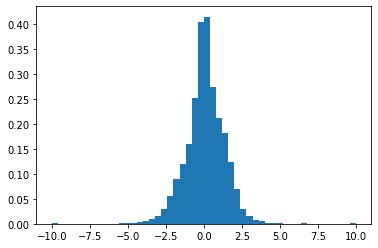

In [35]:
# Run Gibbs sampler with specified number of chains and iterations per chain
n_iter = 2000
n_chains = 1
initialization = 'Otsu'

mu_1_chain = []
mu_2_chain = []
mu_3_chain = []
sigma_1_chain = []
sigma_2_chain = []
sigma_3_chain = []
w_1_chain = []
w_2_chain = []
w_3_chain = []

for i in range(n_chains):
    print('chain: ', i)
    if i == 0:
        plots = False
    else:
        plots = False
        
    [mu_1_vals, mu_2_vals, mu_3_vals, sigma_1_vals, sigma_2_vals, sigma_3_vals, w_1_vals, w_2_vals, w_3_vals, cat_var] = Gibbs_sampling_gauss_mix(velocity_data, n_iter, initialization, plots)
    mu_1_chain.append([mu_1_vals])
    mu_2_chain.append([mu_2_vals])
    mu_3_chain.append([mu_3_vals])
    sigma_1_chain.append([sigma_1_vals])
    sigma_2_chain.append([sigma_2_vals])
    sigma_3_chain.append([sigma_3_vals])
    w_1_chain.append([w_1_vals])
    w_2_chain.append([w_2_vals])
    w_3_chain.append([w_3_vals])

mu_1_vals std dev: 0.0134
mu_1_vals SEM:  0.0003
mu_1_vals 99% conf int:  (0.233, 0.3021)
mu_2_vals std dev: 0.0075
mu_2_vals SEM:  0.0002
mu_2_vals 99% conf int:  (-0.0008, 0.0382)
mu_3_vals std dev: 0.0221
mu_3_vals SEM:  0.0005
mu_3_vals 99% conf int:  (0.1889, 0.303)


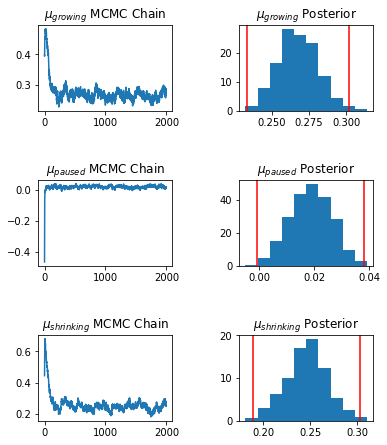

In [36]:
mu_1_std = np.std(mu_1_vals[300:])
print('mu_1_vals std dev:', round(np.std(mu_1_vals[300:]),4))
print('mu_1_vals SEM: ', round(stats.sem(mu_1_vals[300:]),4))

confidence = 0.99

n = len(mu_1_vals[300:])
m = np.mean(mu_1_vals[300:])
std_err = np.std(mu_1_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

mu_1_conf_int = [m-h, m+h]
print('mu_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

mu_2_std = np.std(mu_2_vals[300:])
print('mu_2_vals std dev:', round(np.std(mu_2_vals[300:]),4))
print('mu_2_vals SEM: ', round(stats.sem(mu_2_vals[300:]),4))

confidence = 0.99

n = len(mu_2_vals[300:])
m = np.mean(mu_2_vals[300:])
std_err = np.std(mu_2_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

mu_2_conf_int = [m-h, m+h]
print('mu_2_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


mu_3_std = np.std(mu_3_vals[300:])
print('mu_3_vals std dev:', round(np.std(mu_3_vals[300:]),4))
print('mu_3_vals SEM: ', round(stats.sem(mu_3_vals[300:]),4))

confidence = 0.99

n = len(mu_3_vals[300:])
m = np.mean(mu_3_vals[300:])
std_err = np.std(mu_3_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

mu_3_conf_int = [m-h, m+h]
print('mu_3_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

for i in range(n_chains):
    mu_1_vals = mu_1_chain[i][0]
    mu_2_vals = mu_2_chain[i][0]
    mu_3_vals = mu_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(mu_1_vals)
    plt.title(r'$\mu_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(mu_1_vals[300:], density=True)
    plt.axvline(mu_1_conf_int[0], color = 'r')
    plt.axvline(mu_1_conf_int[1], color = 'r')
    plt.title(r'$\mu_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(mu_2_vals)
    plt.title(r'$\mu_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(mu_2_vals[300:], density=True)
    plt.axvline(mu_2_conf_int[0], color = 'r')
    plt.axvline(mu_2_conf_int[1], color = 'r')
    plt.title(r'$\mu_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(mu_3_vals)
    plt.title(r'$\mu_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(mu_3_vals[300:], density=True)
    plt.axvline(mu_3_conf_int[0], color = 'r')
    plt.axvline(mu_3_conf_int[1], color = 'r')
    plt.title(r'$\mu_{shrinking}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()


sigma_1_vals std dev: 0.0076
sigma_1_vals SEM:  0.0002
sigma_1_vals 99% conf int:  (0.4697, 0.5087)
sigma_2_vals std dev: 0.0108
sigma_2_vals SEM:  0.0003
sigma_2_vals 99% conf int:  (0.3472, 0.4028)
sigma_3_vals std dev: 0.0117
sigma_3_vals SEM:  0.0003
sigma_3_vals 99% conf int:  (0.5376, 0.5977)


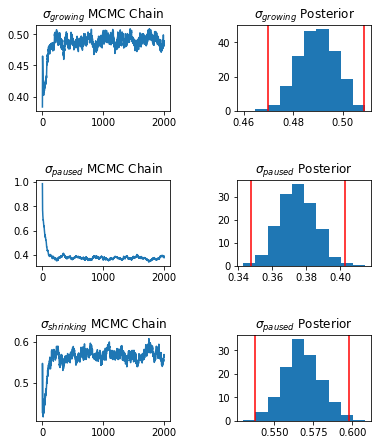

In [37]:
sigma_1_std = np.std(sigma_1_vals[300:])
print('sigma_1_vals std dev:', round(np.std(sigma_1_vals[300:]),4))
print('sigma_1_vals SEM: ', round(stats.sem(sigma_1_vals[300:]),4))

confidence = 0.99

n = len(sigma_1_vals[300:])
m = np.mean(sigma_1_vals[300:])
std_err = np.std(sigma_1_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

sigma_1_conf_int = [m-h, m+h]
print('sigma_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

sigma_2_std = np.std(sigma_2_vals[300:])
print('sigma_2_vals std dev:', round(np.std(sigma_2_vals[300:]),4))
print('sigma_2_vals SEM: ', round(stats.sem(sigma_2_vals[300:]),4))

confidence = 0.99

n = len(sigma_2_vals[300:])
m = np.mean(sigma_2_vals[300:])
std_err = np.std(sigma_2_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

sigma_2_conf_int = [m-h, m+h]
print('sigma_2_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


sigma_3_std = np.std(sigma_3_vals[300:])
print('sigma_3_vals std dev:', round(np.std(sigma_3_vals[300:]),4))
print('sigma_3_vals SEM: ', round(stats.sem(sigma_3_vals[300:]),4))

confidence = 0.99

n = len(sigma_3_vals[300:])
m = np.mean(sigma_3_vals[300:])
std_err = np.std(sigma_3_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

sigma_3_conf_int = [m-h, m+h]
print('sigma_3_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

for i in range(n_chains):
    sigma_1_vals = sigma_1_chain[i][0]
    sigma_2_vals = sigma_2_chain[i][0]
    sigma_3_vals = sigma_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(sigma_1_vals)
    plt.title(r'$\sigma_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(sigma_1_vals[200:], density=True)
    plt.axvline(sigma_1_conf_int[0], color = 'r')
    plt.axvline(sigma_1_conf_int[1], color = 'r')
    plt.title(r'$\sigma_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(sigma_2_vals)
    plt.title(r'$\sigma_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(sigma_2_vals[200:], density=True)
    plt.axvline(sigma_2_conf_int[0], color = 'r')
    plt.axvline(sigma_2_conf_int[1], color = 'r')
    plt.title(r'$\sigma_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(sigma_3_vals)
    plt.title(r'$\sigma_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(sigma_3_vals[200:], density=True)
    plt.axvline(sigma_3_conf_int[0], color = 'r')
    plt.axvline(sigma_3_conf_int[1], color = 'r')
    plt.title(r'$\sigma_{paused}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()

w_1_vals std dev: 0.0058
w_1_vals SEM:  0.0001
w_1_vals 99% conf int:  (0.2866, 0.3167)
w_2_vals std dev: 0.011
w_2_vals SEM:  0.0003
w_2_vals 99% conf int:  (0.425, 0.4816)
w_3_vals std dev: 0.007
w_3_vals SEM:  0.0002
w_3_vals 99% conf int:  (0.2271, 0.263)


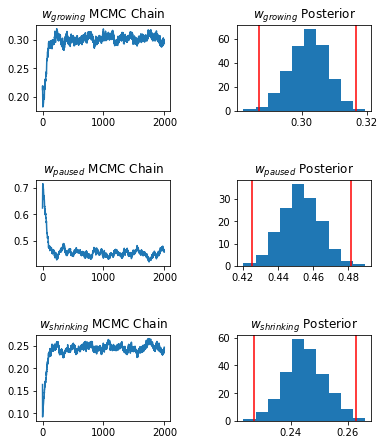

In [38]:
w_1_std = np.std(w_1_vals[300:])
print('w_1_vals std dev:', round(np.std(w_1_vals[300:]),4))
print('w_1_vals SEM: ', round(stats.sem(w_1_vals[300:]),4))

confidence = 0.99

n = len(w_1_vals[300:])
m = np.mean(w_1_vals[300:])
std_err = np.std(w_1_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

w_1_conf_int = [m-h, m+h]
print('w_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

w_2_std = np.std(w_2_vals[300:])
print('w_2_vals std dev:', round(np.std(w_2_vals[300:]),4))
print('w_2_vals SEM: ', round(stats.sem(w_2_vals[300:]),4))

confidence = 0.99

n = len(w_2_vals[300:])
m = np.mean(w_2_vals[300:])
std_err = np.std(w_2_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

w_2_conf_int = [m-h, m+h]
print('w_2_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


w_3_std = np.std(w_3_vals[300:])
print('w_3_vals std dev:', round(np.std(w_3_vals[300:]),4))
print('w_3_vals SEM: ', round(stats.sem(w_3_vals[300:]),4))

confidence = 0.99

n = len(w_3_vals[300:])
m = np.mean(w_3_vals[300:])
std_err = np.std(w_3_vals[300:])
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

w_3_conf_int = [m-h, m+h]
print('w_3_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

for i in range(n_chains): 
    w_1_vals = w_1_chain[i][0]
    w_2_vals = w_2_chain[i][0]
    w_3_vals = w_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(w_1_vals)
    plt.title(r'$w_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(w_1_vals[200:], density=True)
    plt.axvline(w_1_conf_int[0], color = 'r')
    plt.axvline(w_1_conf_int[1], color = 'r')
    plt.title(r'$w_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(w_2_vals)
    plt.title(r'$w_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(w_2_vals[200:], density=True)
    plt.axvline(w_2_conf_int[0], color = 'r')
    plt.axvline(w_2_conf_int[1], color = 'r')
    plt.title(r'$w_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(w_3_vals)
    plt.title(r'$w_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(w_3_vals[200:], density=True)
    plt.axvline(w_3_conf_int[0], color = 'r')
    plt.axvline(w_3_conf_int[1], color = 'r')
    plt.title(r'$w_{shrinking}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()

In [39]:
mu_1_mean = np.mean(mu_1_vals[300:])
mu_2_mean = np.mean(mu_2_vals[300:])
mu_3_mean = np.mean(mu_3_vals[300:])

sigma_1_mean = np.mean(sigma_1_vals[300:])
sigma_2_mean = np.mean(sigma_2_vals[300:])
sigma_3_mean = np.mean(sigma_3_vals[300:])

w_1_mean = np.mean(w_1_vals[300:])
w_2_mean = np.mean(w_2_vals[300:])
w_3_mean = np.mean(w_3_vals[300:])

In [40]:
# Experimental model
# Obtain log normal PDFs

log_norm_positive = log_Normal(x[np.where(x > 0)], mu_1_mean, sigma_1_mean)
log_norm_negative = log_Normal(x[np.where(x < 0)], mu_3_mean, sigma_3_mean)

# Pad with zeros
log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(x) - len(log_norm_negative))])
log_norm_positive = np.concatenate([np.zeros(len(x) - len(log_norm_positive)), log_norm_positive])

experimental_mixture = w_1_mean*log_norm_positive + w_2_mean*norm.pdf(x, mu_2_mean, sigma_2_mean) + w_3_mean*log_norm_negative

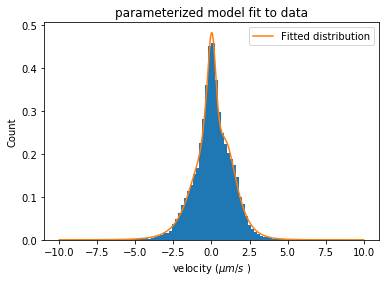

In [44]:
plt.hist(velocity_data, bins = 100, density=True)
plt.plot(x, experimental_mixture, label='Fitted distribution')
plt.title('parameterized model fit to data')
plt.xlabel(r'velocity ($\mu m/s$ )')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [42]:
sort_velocity_data = np.sort(velocity_data)
Growth = sort_velocity_data[np.where(cat_var == 1)]
Paused = sort_velocity_data[np.where(cat_var == 2)]
Shrinking = sort_velocity_data[np.where(cat_var == 3)]

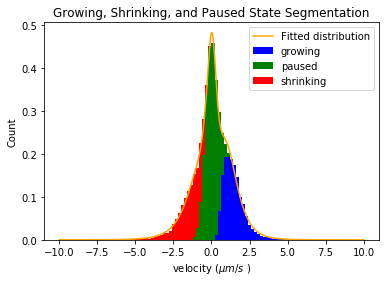

In [48]:
plt.hist([Growth, Paused, Shrinking], bins = 100, density = True, color = ['blue', 'green', 'red'], stacked = True, label=['growing', 'paused', 'shrinking'])
plt.plot(x, experimental_mixture, color = 'orange', label='Fitted distribution')
plt.title('Growing, Shrinking, and Paused State Segmentation')
plt.xlabel(r'velocity ($\mu m/s$ )')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()